In [1]:
import spacy
nlp = spacy.blank('id')
import gensim
import pandas as pd
import nltk
import numpy as np
from sklearn import preprocessing

In [2]:
df = pd.read_excel("dataset_twitter.xlsx")
df.head()

,label,komentar
0,positif,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...
1,positif,"Sharing pengalaman aja, kemarin jam 18.00 bata..."
2,positif,Sharing sama temen tuh emg guna bgt. Disaat lu...
3,positif,"sangat bersyukur bisa mendoakan kakeknya, Bung..."
4,positif,H-9. Mau ke bank rame bgt ampe antrian tempat ...


In [3]:
import re
import string
nltk.download('punkt')

komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,label,komentar
0,positif,"[kepingin, gudeg, mbarek, bu, hj, amad, foto, ..."
1,positif,"[sharing, pengalaman, aja, kemarin, jam, batal..."
2,positif,"[sharing, sama, temen, tuh, emg, guna, bgt, di..."
3,positif,"[sangat, bersyukur, bisa, mendoakan, kakeknya,..."
4,positif,"[h, mau, ke, bank, rame, bgt, ampe, antrian, t..."
...,...,...
3110,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
3111,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
3112,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
3113,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [4]:
df = df[df.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
from gensim.models.fasttext import FastText
model = FastText.load('Model/XGB.bin')

In [7]:
from MeanVectorizer import MeanEmbeddingVectorizer
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [8]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [9]:
import xgboost as xgb
from xgboost import XGBClassifier

In [10]:
lc=preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [11]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [12]:
weights = y_train_enc
weights = np.choose(weights, [0.94, 1.1, 1])

train=xgb.DMatrix(X_train_vector,label=y_train_enc, weight=weights)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

print("\nIni Weights\n", weights, "\n")
print("Ini y_train_encode\n", y_train_enc, "\n")


Ini Weights
 [0.94 0.94 1.1  ... 1.1  1.   1.  ] 

Ini y_train_encode
 [0 0 1 ... 1 2 2] 



In [13]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000
    
param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 7
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

# param['num_class']=len(set(y))
# param['learning_rate'] = 0.001
# param['max_depth'] = 7
# param['min_child_weight'] = 10
# param['gamma'] = 2
# param['reg_alpha'] = 0.9
# param['reg_lambda'] = 4
# param['subsample'] = 0.7
# param['colsample_bytree'] = 1
# param['objective'] = 'multi:softmax'
# param['scale_pos_weight'] = 1

watchlist = [(train, 'train'), (test, 'test')]
# num_round = 100
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.39152	test-merror:0.57945
[1]	train-merror:0.30433	test-merror:0.55698
[2]	train-merror:0.24722	test-merror:0.55698
[3]	train-merror:0.22521	test-merror:0.51043
[4]	train-merror:0.20120	test-merror:0.49438
[5]	train-merror:0.18948	test-merror:0.48636
[6]	train-merror:0.16558	test-merror:0.47994
[7]	train-merror:0.14512	test-merror:0.47191
[8]	train-merror:0.13248	test-merror:0.47352
[9]	train-merror:0.12034	test-merror:0.45907
[10]	train-merror:0.11163	test-merror:0.44944
[11]	train-merror:0.09619	test-merror:0.46870
[12]	train-merror:0.08706	test-merror:0.46870
[13]	train-merror:0.09445	test-merror:0.45907
[14]	train-merror:0.08236	test-merror:0.46388
[15]	train-merror:0.08548	test-merror:0.45907
[16]	train-merror:0.08129	test-merror:0.45746
[17]	train-merror:0.07875	test-merror:0.45907
[18]	train-merror:0.07657	test-merror:0.45586
[19]	train-merror:0.07808	test-merror:0.45265
[20]	train-merror:0.07579	test-merror:0.45907
[21]	train-merror:0.07415	test-merror:0.4478

[177]	train-merror:0.01384	test-merror:0.41734
[178]	train-merror:0.01259	test-merror:0.41894
[179]	train-merror:0.01303	test-merror:0.42215
[180]	train-merror:0.01303	test-merror:0.41734
[181]	train-merror:0.01259	test-merror:0.41894
[182]	train-merror:0.01222	test-merror:0.41734
[183]	train-merror:0.01222	test-merror:0.41734
[184]	train-merror:0.01189	test-merror:0.41573
[185]	train-merror:0.01224	test-merror:0.41734
[186]	train-merror:0.01228	test-merror:0.41734
[187]	train-merror:0.01266	test-merror:0.41894
[188]	train-merror:0.01228	test-merror:0.41894
[189]	train-merror:0.01262	test-merror:0.41734
[190]	train-merror:0.01305	test-merror:0.41252
[191]	train-merror:0.01270	test-merror:0.41091
[192]	train-merror:0.01270	test-merror:0.41091
[193]	train-merror:0.01193	test-merror:0.41413
[194]	train-merror:0.01232	test-merror:0.40610
[195]	train-merror:0.01232	test-merror:0.41091
[196]	train-merror:0.01230	test-merror:0.40770
[197]	train-merror:0.01270	test-merror:0.40449
[198]	train-m

[352]	train-merror:0.00291	test-merror:0.39968
[353]	train-merror:0.00291	test-merror:0.39968
[354]	train-merror:0.00291	test-merror:0.39807
[355]	train-merror:0.00291	test-merror:0.39968
[356]	train-merror:0.00291	test-merror:0.40289
[357]	train-merror:0.00291	test-merror:0.40289
[358]	train-merror:0.00291	test-merror:0.39968
[359]	train-merror:0.00291	test-merror:0.39968
[360]	train-merror:0.00291	test-merror:0.40128
[361]	train-merror:0.00291	test-merror:0.40289
[362]	train-merror:0.00291	test-merror:0.40128
[363]	train-merror:0.00291	test-merror:0.40128
[364]	train-merror:0.00291	test-merror:0.39968
[365]	train-merror:0.00291	test-merror:0.39968
[366]	train-merror:0.00291	test-merror:0.39807
[367]	train-merror:0.00291	test-merror:0.39968
[368]	train-merror:0.00291	test-merror:0.39807
[369]	train-merror:0.00291	test-merror:0.40128
[370]	train-merror:0.00291	test-merror:0.40289
[371]	train-merror:0.00291	test-merror:0.40128
[372]	train-merror:0.00291	test-merror:0.40128
[373]	train-m

[527]	train-merror:0.00040	test-merror:0.40449
[528]	train-merror:0.00040	test-merror:0.40289
[529]	train-merror:0.00040	test-merror:0.40449
[530]	train-merror:0.00040	test-merror:0.40128
[531]	train-merror:0.00040	test-merror:0.40128
[532]	train-merror:0.00040	test-merror:0.39807
[533]	train-merror:0.00040	test-merror:0.39647
[534]	train-merror:0.00040	test-merror:0.39807
[535]	train-merror:0.00040	test-merror:0.39807
[536]	train-merror:0.00040	test-merror:0.39807
[537]	train-merror:0.00040	test-merror:0.39968
[538]	train-merror:0.00040	test-merror:0.40128
[539]	train-merror:0.00040	test-merror:0.39807
[540]	train-merror:0.00040	test-merror:0.39968
[541]	train-merror:0.00040	test-merror:0.40449
[542]	train-merror:0.00040	test-merror:0.40449
[543]	train-merror:0.00040	test-merror:0.40289
[544]	train-merror:0.00040	test-merror:0.40289
[545]	train-merror:0.00040	test-merror:0.40610
[546]	train-merror:0.00040	test-merror:0.40449
[547]	train-merror:0.00040	test-merror:0.40289
[548]	train-m

[702]	train-merror:0.00000	test-merror:0.39968
[703]	train-merror:0.00000	test-merror:0.39807
[704]	train-merror:0.00000	test-merror:0.39968
[705]	train-merror:0.00000	test-merror:0.39807
[706]	train-merror:0.00000	test-merror:0.39807
[707]	train-merror:0.00000	test-merror:0.39968
[708]	train-merror:0.00000	test-merror:0.39807
[709]	train-merror:0.00000	test-merror:0.39807
[710]	train-merror:0.00000	test-merror:0.39807
[711]	train-merror:0.00000	test-merror:0.39807
[712]	train-merror:0.00000	test-merror:0.39647
[713]	train-merror:0.00000	test-merror:0.39647
[714]	train-merror:0.00000	test-merror:0.39647
[715]	train-merror:0.00000	test-merror:0.39807
[716]	train-merror:0.00000	test-merror:0.39807
[717]	train-merror:0.00000	test-merror:0.39807
[718]	train-merror:0.00000	test-merror:0.39807
[719]	train-merror:0.00000	test-merror:0.39807
[720]	train-merror:0.00000	test-merror:0.39807
[721]	train-merror:0.00000	test-merror:0.39807
[722]	train-merror:0.00000	test-merror:0.39968
[723]	train-m

[877]	train-merror:0.00000	test-merror:0.39486
[878]	train-merror:0.00000	test-merror:0.39486
[879]	train-merror:0.00000	test-merror:0.39647
[880]	train-merror:0.00000	test-merror:0.39647
[881]	train-merror:0.00000	test-merror:0.39647
[882]	train-merror:0.00000	test-merror:0.39486
[883]	train-merror:0.00000	test-merror:0.39486
[884]	train-merror:0.00000	test-merror:0.39486
[885]	train-merror:0.00000	test-merror:0.39486
[886]	train-merror:0.00000	test-merror:0.39486
[887]	train-merror:0.00000	test-merror:0.39486
[888]	train-merror:0.00000	test-merror:0.39486
[889]	train-merror:0.00000	test-merror:0.39486
[890]	train-merror:0.00000	test-merror:0.39486
[891]	train-merror:0.00000	test-merror:0.39486
[892]	train-merror:0.00000	test-merror:0.39486
[893]	train-merror:0.00000	test-merror:0.39486
[894]	train-merror:0.00000	test-merror:0.39326
[895]	train-merror:0.00000	test-merror:0.39326
[896]	train-merror:0.00000	test-merror:0.39486
[897]	train-merror:0.00000	test-merror:0.39486
[898]	train-m

In [14]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [15]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.6067415730337079 

Train Score
 1.0 

CONFUSSION MATRIX
 [[158  42  20]
 [ 50 108  42]
 [ 38  53 112]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.64      0.72      0.68       220
      netral       0.53      0.54      0.54       200
     positif       0.64      0.55      0.59       203

    accuracy                           0.61       623
   macro avg       0.61      0.60      0.60       623
weighted avg       0.61      0.61      0.61       623
 



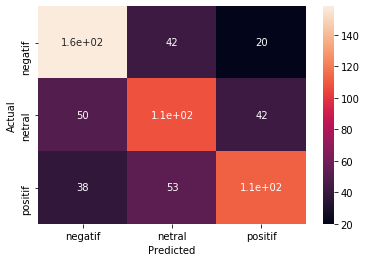

In [17]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [18]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])